<a href="https://colab.research.google.com/github/JCaballerot/Consultoria_ASEI/blob/main/Model_development/Miraflores/modelDevelopment_zona2_M_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5>Forecasting Miraflores Zona 2
</font></h1>

---

# Librerias



Cargamos las librerías que utilizaremos en el proyecto

In [ ]:
import pandas as pd

import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from sklearn.metrics import *

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",  color='red')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)

# Data

Importamos la información desde un archivo csv cargado en el file temporal y nos quedamos con los datos de la zona 2

In [ ]:
target = 'Venta_zona_2'

pddf = pd.read_csv('datos_miraflores.csv', delimiter=',', index_col=['codmes'], parse_dates=['codmes']).fillna(0)
pddf = pddf[[target]]

pddf[target+'_lag2'] = pddf[target].shift(2)
pddf[target+'_lag3'] = pddf[target].shift(3)


In [ ]:
macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])
variables_macro = macro.columns.tolist()
macro[variables_macro] = macro[variables_macro].shift(3)


In [ ]:
asei = pd.read_csv('variables_asei_new.csv', delimiter = ';', index_col=['codmes'], parse_dates=['codmes'])
variables_asei = asei.columns.tolist()
asei[variables_asei] = asei[variables_asei].shift(2)

In [ ]:

pddf2 = pd.merge(pddf, macro, on = 'codmes', how='left').copy()
pddf2 = pd.merge(pddf2, asei, on = 'codmes', how='left')

variables = variables_macro + variables_asei + [target+'_lag2', target+'_lag3']


In [ ]:
pddfRes = pddf2.copy()

pddfRes[[x + '_avg3' for x in variables]] = pddfRes[variables].rolling(3, min_periods = 3).mean()
pddfRes[[x + '_avg6' for x in variables]] = pddfRes[variables].rolling(6, min_periods = 6).mean()

pddfRes = pddfRes.iloc[8:]


In [ ]:
for x in variables:
  pddfRes[x + '_rat3to6'] = pddfRes[x + '_avg3']/pddfRes[x + '_avg6']
  

In [ ]:

variables_f = variables_macro +\
              variables_asei +\
              [target+'_lag2', target+'_lag3'] +\
              [x + '_avg3' for x in variables] +\
              [x + '_avg6' for x in variables] +\
              [x + '_rat3to6' for x in variables]


In [ ]:
pddfRes['intercept'] = 1

In [ ]:
test_size = 2

data = pddfRes.copy().dropna()
X_train = pddfRes[:-test_size].dropna()
X_test  = pddfRes[-test_size:].dropna()


In [ ]:
# Estandarización

X_train[[x + '_std' for x in variables_f]] = (X_train[variables_f] - X_train[variables_f].mean())/X_train[variables_f].std()
X_test[[x + '_std'  for x in variables_f]] = (X_test[variables_f]  - X_train[variables_f].mean())/X_train[variables_f].std()
data[[x + '_std'    for x in variables_f]] = (data[variables_f]    - X_train[variables_f].mean())/X_train[variables_f].std()



In [ ]:
X_train[['ind_prec_cons_lima_met_alim_ener_avg3', 'exp_PBI_avg3', 'flg_feia_avg3']].mean()

ind_prec_cons_lima_met_alim_ener_avg3    89.775296
exp_PBI_avg3                              0.045776
flg_feia_avg3                             0.340741
dtype: float64

In [ ]:
X_train[['ind_prec_cons_lima_met_alim_ener_avg3', 'exp_PBI_avg3', 'flg_feia_avg3']].std()

ind_prec_cons_lima_met_alim_ener_avg3    3.052684
exp_PBI_avg3                             0.016491
flg_feia_avg3                            0.194481
dtype: float64

# Forecasting

### Exploracion

Muestreamos la data en train y test bajo metodología OOT

In [ ]:
plotMovingAverage(data[target], 6)

In [ ]:
plotMovingAverage(data[target], 6, plot_intervals=True, scale=1.64, plot_anomalies=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(X_train[target].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Dado que el valor p es mayor que el nivel de significancia (0,05), diferenciemos las series y veamos cómo se ve el gráfico de autocorrelación.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train[target]); axes[0, 0].set_title('Original Series')
plot_acf(X_train[target], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train[target].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train[target].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train[target].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train[target].diff().diff().dropna(), ax=axes[2, 1])

plt.xticks(rotation=90)
plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con dos órdenes de diferenciación.

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(X_train[target].diff().dropna(), ax=axes[1])

plt.xticks(rotation=90)
plt.show()

Podemos ver que el retraso 1 de PACF es bastante significativo ya que está muy por encima de la línea de significancia. Entonces, fijaremos el valor de p como 1.

### MA (q) 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(X_train[target].diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()


Podemos ver que un 1 retraso están muy por encima de la línea de significación. Entonces, fijaremos q como 1. Si hay alguna duda, iremos con el modelo más simple que explica suficientemente la Y

### Arima

Ahora, hemos determinado los valores de p, d y q. Disponemos de todo lo necesario para adaptarse al modelo ARIMA. Usaremos la implementación ARIMA() en el paquete statsmodels.
(p,d,q)

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X_train[target], label='Original Series')
axes[0].plot(X_train[target].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(X_train[target], label='Original Series')
axes[1].plot(X_train[target].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas Zona 3', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

features = [target + '_lag2_avg3']

# 2,1,1 ARIMA Model
model = ARIMA(endog = X_train[target], 
              exog = X_train[features],  
              order=(1,2,1))

model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_2   No. Observations:                   43
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -172.267
Method:                       css-mle   S.D. of innovations             12.663
Date:                Sun, 24 Jul 2022   AIC                            354.534
Time:                        05:52:51   BIC                            363.340
Sample:                             2   HQIC                           357.781
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0173      0.839     -0.021      0.984      -1.662       1.627
Venta_zona_2_lag2_avg3     0.0021      0.022      0.096      0.924      -0.040       0.044
ar.L

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:

import pickle
pickle.dump(model_fit, open("./arima_mz2.ml", 'wb'))


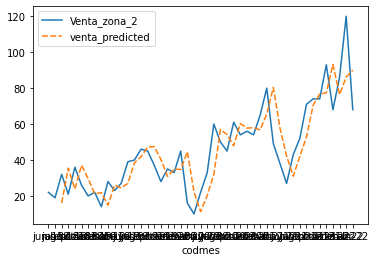

In [ ]:

fc, se, conf  = model_fit.forecast(test_size, exog = X_test[features], alpha=0.05)
model_res = model_fit.predict(start = X_train.index[2], 
                                end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted'] = model_res
data_res.iloc[-test_size:]['venta_predicted'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted']])


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen correctos con una media cercana a cero y una varianza uniforme. Grafiquemos los valores reales contra los valores ajustados usando plot_predict().

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
data_res[['venta_predicted',target]]

In [ ]:
data_res[['venta_predicted',target]].to_csv('results_JM_zona2.csv', index=0)

In [ ]:

data = data_res.copy().dropna()
X_train = data_res[:-test_size].dropna()
X_test  = data_res[-test_size:].dropna()



In [ ]:
X_test[['venta_predicted', target]]

In [ ]:
X_test[['venta_predicted', target]].corr()**2

,venta_predicted,Venta_zona_2
venta_predicted,1.0,1.0
Venta_zona_2,1.0,1.0


# Inputs Regresión

In [ ]:
correlations = pd.DataFrame()

for col in variables_f:
  data_temp = X_train[[target, col]]
  correlation = data_temp[col].corr(data_temp[target])
  temp = pd.DataFrame({'target': [target],'variable': [col], 'correlacion' : [correlation]})
  correlations = correlations.append(temp)

correlations['correlacion_abs'] = correlations.correlacion.apply(lambda x: abs(x))
correlations['r2'] = correlations.correlacion.apply(lambda x: x**2)

correlations.sort_values(by = 'correlacion_abs', ascending = False, inplace = True)


In [ ]:
correlations.head(50)

# Regresion

In [ ]:
import statsmodels.api as sm

features = ['intercept', 'exp_PBI_avg3_std', 'ind_prec_cons_lima_met_alim_ener_avg3_std',
            'flg_feia_avg3_std']

# Fit and summarize OLS model
mod = sm.OLS(X_train[target], 
             X_train[features])

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Venta_zona_2   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     36.78
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           1.87e-11
Time:                        05:53:20   Log-Likelihood:                -161.27
No. Observations:                  43   AIC:                             330.5
Df Residuals:                      39   BIC:                             337.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [ ]:
3.8777/(5.9631 + 15.6759 + 3.8777)

0.1519671430866844

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(X_train[features].corr(), annot=True)
plt.show()

In [ ]:

data_res['macro_pred'] = 42.7099 +\
                         5.9631*data_res.exp_PBI_avg3_std +\
                         15.6759*data_res.ind_prec_cons_lima_met_alim_ener_avg3_std +\
                         3.8777*data_res.flg_feia_avg3_std

data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()


In [ ]:
#target + '_lag3_avg3'
ensemble = ['venta_predicted', 'macro_pred']

# 2,1,1 ARIMA Model
model_ff = ARIMA(endog = X_train[target], 
                 exog = X_train[ensemble],  
              order=(3,1,2))

model_fit_ff = model_ff.fit()
print(model_fit_ff.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.Venta_zona_2   No. Observations:                   42
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -149.451
Method:                       css-mle   S.D. of innovations              7.979
Date:                Sun, 24 Jul 2022   AIC                            316.902
Time:                        05:53:34   BIC                            332.541
Sample:                             1   HQIC                           322.634
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0210      4.801      0.213      0.833      -8.390      10.432
venta_predicted         -1.1156      0.241     -4.624      0.000      -1.588      -0.643
macro_pred  

In [ ]:

import pickle
pickle.dump(model_fit_ff, open("./var_mz2.ml", 'wb'))

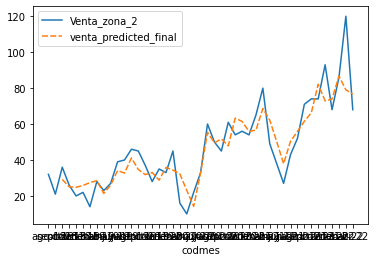

In [ ]:

fc, se, conf  = model_fit_ff.forecast(test_size, 
                                      exog = X_test[['venta_predicted', 'macro_pred']], alpha=0.05)

model_res = model_fit_ff.predict(start = X_train.index[2], 
                                 end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted_final'] = model_res
data_res.iloc[-test_size:]['venta_predicted_final'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted_final']])


In [ ]:
data_res[[target, 'venta_predicted', 'macro_pred', 'venta_predicted_final']]

,Venta_zona_2,venta_predicted,macro_pred,venta_predicted_final
codmes,,,,
ago-18,32,16.031112,28.040954,NaN
sept-18,21,35.474154,21.531488,NaN
oct-18,36,23.819062,29.533635,29.186729
nov-18,26,37.057834,24.741473,25.045290
dic-18,20,29.662694,26.308425,24.828519
ene-19,22,21.220210,27.223059,25.822974
feb-19,14,21.809533,28.092730,27.428457
mar-19,28,14.797572,28.406908,28.496695
abr-19,23,26.016501,22.207506,21.371497


In [ ]:
mod = sm.OLS(X_train[target], X_train[['venta_predicted', 'macro_pred', 'intercept']])
res = mod.fit()
print(res.summary())

In [ ]:

data_res['venta_predicted_final'] = 0.1938*data_res.venta_predicted + 0.9125*data_res.macro_pred - 6.1913


data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()



In [ ]:
X_train[['venta_predicted_final', target]].corr()**2

,venta_predicted_final,Venta_zona_1
venta_predicted_final,1.000000,0.250031
Venta_zona_1,0.250031,1.000000


In [ ]:
data[['venta_predicted',
      'venta_predicted_final', target]].to_csv('results_zona1.csv', index=0)

In [ ]:
data[['venta_predicted',
      'venta_predicted_final', target]]

In [ ]:
X_test[features]

,Venta_zona_1_lag3_avg3
codmes,
abr-22,63.000000
may-22,55.333333


# Implementación

In [ ]:
data[[target + '_lag2_avg3', 'exp_PBI_avg3_std', 'ind_prec_cons_lima_met_alim_ener_avg3_std', 'flg_feia_avg3_std']]

,Venta_zona_2_lag2_avg3,exp_PBI_avg3_std,ind_prec_cons_lima_met_alim_ener_avg3_std,flg_feia_avg3_std
codmes,,,,
ago-18,23.333333,-0.471490,-1.170967,1.675880
sept-18,23.000000,-0.431065,-1.177619,-0.038088
oct-18,24.333333,-0.390640,-1.106501,1.675880
nov-18,24.000000,-0.350215,-1.003602,-0.038088
dic-18,29.666667,-0.350215,-0.903643,-0.038088
ene-19,27.666667,-0.360321,-0.841452,-0.038088
feb-19,27.333333,-0.380534,-0.778285,-0.038088
mar-19,22.666667,-0.400746,-0.750554,-0.038088
abr-19,18.666667,-0.390640,-0.725893,-1.752056


In [ ]:
input = pd.DataFrame({'Venta_zona_2_lag2_avg3' : [82, 82, 82, 82, 82, 82],
                      'exp_PBI_avg3_std' : [-1.138502]*6,
                      'ind_prec_cons_lima_met_alim_ener_avg3_std' : [3.280410]*6,
                      'flg_feia_avg3_std' : [-0.038088]*6
                      },
                      index = ['may','jun-22', 'jul-22', 'ago-22', 'sept-22', 'oct-22'])         

                                          


In [ ]:
fc_pred, se, conf  = model_fit.forecast(6, exog = input['Venta_zona_2_lag2_avg3'], alpha=0.05)
input['venta_predicted'] = fc_pred
fc_pred

array([ 86.13312897,  89.96660192,  93.25468393,  96.83319291,
       100.53758926, 104.40026435])

In [ ]:

input['macro_pred'] = 42.7099 +\
                         5.9631*input.exp_PBI_avg3_std +\
                         15.6759*input.ind_prec_cons_lima_met_alim_ener_avg3_std +\
                         3.8777*input.flg_feia_avg3_std
                         
#input['venta_predicted_final'] = 0.1938*input.venta_predicted + 0.9125*input.macro_pred - 6.1913


In [ ]:
fc_pred, se, conf  = model_fit_ff.forecast(6, exog = input[['venta_predicted', 'macro_pred']], alpha=0.05)
input['venta_predicted_final'] = fc_pred
input['venta_predicted_final']
fc_pred

array([82.2143376 , 79.19621784, 75.83204487, 68.71035233, 55.47140704,
       37.67628461])

In [ ]:
input['macro_pred']

may        87.196584
jun-22     87.196584
jul-22     87.196584
ago-22     87.196584
sept-22    87.196584
oct-22     87.196584
Name: macro_pred, dtype: float64